In [1]:
# importing libraries: 
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from PIL import Image

In [3]:
# Reading image data: 

# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
# nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory( r'E:\Machine Learning\violence_dataset',
                                    target_size=(32, 32),
                                    batch_size=14537,
                                    class_mode='categorical',
                                    shuffle=True )

Found 14537 images belonging to 2 classes.


In [4]:
X, y= next(data) #Fetches a single batch of images (X) and their corresponding labels (y) from the data generator.

In [5]:
X

array([[[[178., 160., 182.],
         [190., 175., 194.],
         [203., 186., 205.],
         ...,
         [197., 179., 191.],
         [223., 210., 219.],
         [194., 177., 193.]],

        [[174., 159., 182.],
         [188., 174., 200.],
         [202., 185., 203.],
         ...,
         [190., 174., 187.],
         [ 96.,  77.,  79.],
         [186., 174., 188.]],

        [[180., 163., 181.],
         [189., 176., 193.],
         [196., 179., 195.],
         ...,
         [172., 135.,   5.],
         [105.,  70.,  48.],
         [ 21.,   0.,   0.]],

        ...,

        [[ 41.,  36.,  43.],
         [ 24.,  23.,  31.],
         [ 50.,  32.,  44.],
         ...,
         [227., 212., 217.],
         [215., 200., 207.],
         [246., 231., 234.]],

        [[171., 166., 188.],
         [166., 155., 185.],
         [ 82.,  78.,  93.],
         ...,
         [253., 238., 241.],
         [252., 237., 244.],
         [248., 233., 236.]],

        [[188., 176., 212.],
       

In [6]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [7]:
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(14537, 32, 32, 3)
Labels shape :(14537, 2)


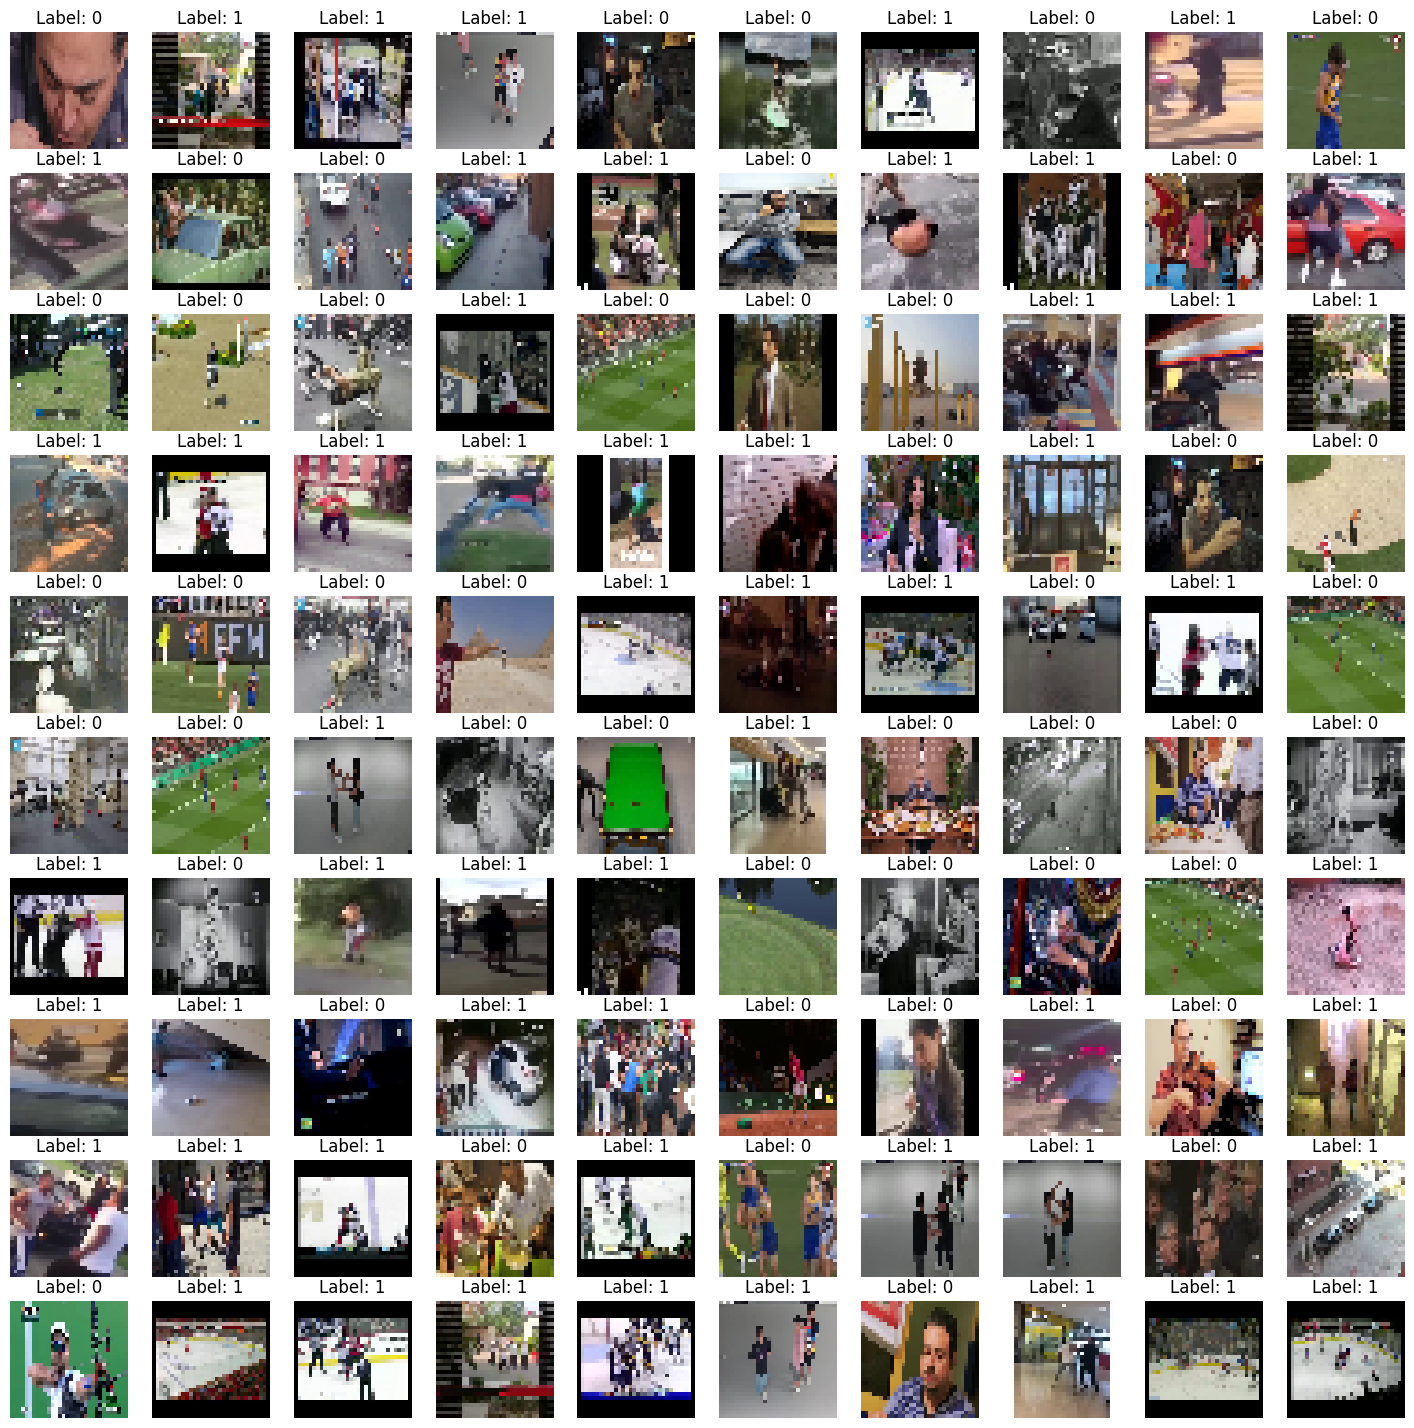

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

In [9]:
# dividing into test and training data: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (11629, 32, 32, 3)
Test Shape : (2908, 32, 32, 3)


In [10]:
# Resnet50 initialization: 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))
nb_classes= [0, 1]
x = resnet.output
x = GlobalAveragePooling2D()(x) # Reduces the spatial dimensions of the feature maps, converting them into a single vector per feature map.
x = Dropout(0.5)(x) #A regularization technique that randomly drops 50% of the neurons during training to prevent overfitting.
predictions = Dense(len(nb_classes), activation= 'sigmoid')(x) #The output layer with len(nb_classes) (2) neurons and a sigmoid activation function, which is suitable for binary classification.
model = Model(inputs = resnet.input, outputs = predictions)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
# compile the model: 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

# adam - to adjust the weights

In [13]:
# creating callbacks: 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

model_check = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max') 
#  Saves the model with the best validation accuracy during training.

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
# Stops training early if the validation accuracy doesn’t improve for 5 epochs, to prevent overfitting

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Reduces the learning rate by a factor of 0.2 if the validation loss plateaus for 5 epochs

csv_logger = CSVLogger('train_log.csv', separator=',')
# Logs training progress to a CSV file

In [14]:
# fitting the model with the data: 

n_epochs = 20
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 144s 324ms/step - accuracy: 0.6323 - loss: 1.0972 - val_accuracy: 0.7768 - val_loss: 0.4614 - learning_rate: 0.0010
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 114s 314ms/step - accuracy: 0.8069 - loss: 0.4294 - val_accuracy: 0.8566 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 113s 311ms/step - accuracy: 0.8722 - loss: 0.3183 - val_accuracy: 0.5825 - val_loss: 2.6304 - learning_rate: 0.0010
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 112s 309ms/step - accuracy: 0.6823 - loss: 0.7337 - val_accuracy: 0.6768 - val_loss: 1.9110 - learning_rate: 0.0010
Epoch 5/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 113s 311ms/step - accuracy: 0.7522 - loss: 0.5208 - val_accuracy: 0.8232 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 6/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 120s 331ms/step - accuracy: 0.8398 - loss: 0.3851 - val_accuracy: 0.8683 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 7/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 113s 310ms/step - accura

In [15]:
# saving the model: 
model.save("violence_detection.keras")

In [26]:
# creating the pickle file: 
import pickle
with open('ViolenceDetection.pickle','wb') as f:
    pickle.dump(model,f)

In [16]:
# loss and accuracy:  
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8709 - loss: 0.2885
Accuracy:  0.8707014918327332 
Loss    :  0.29352042078971863


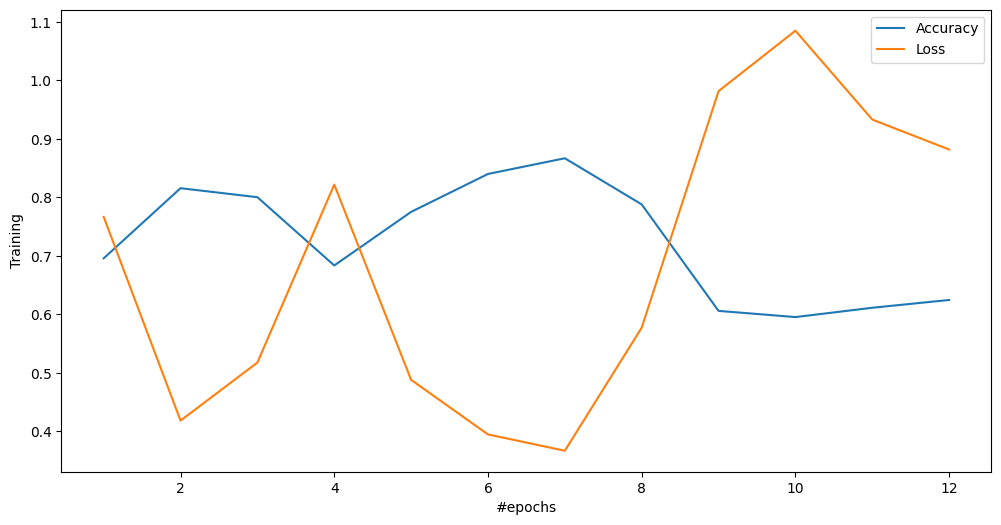

In [17]:
# results visualization: 
import seaborn as sns

q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend()

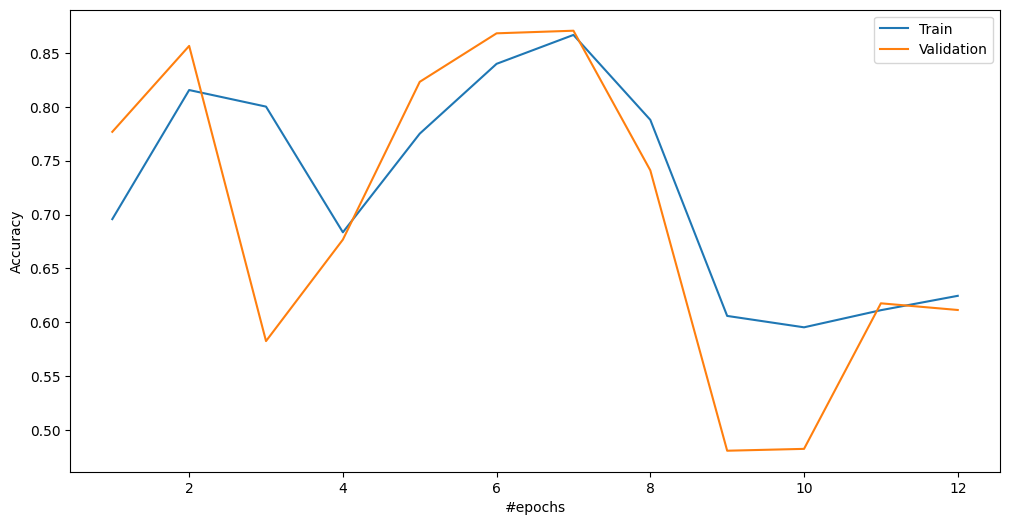

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend()

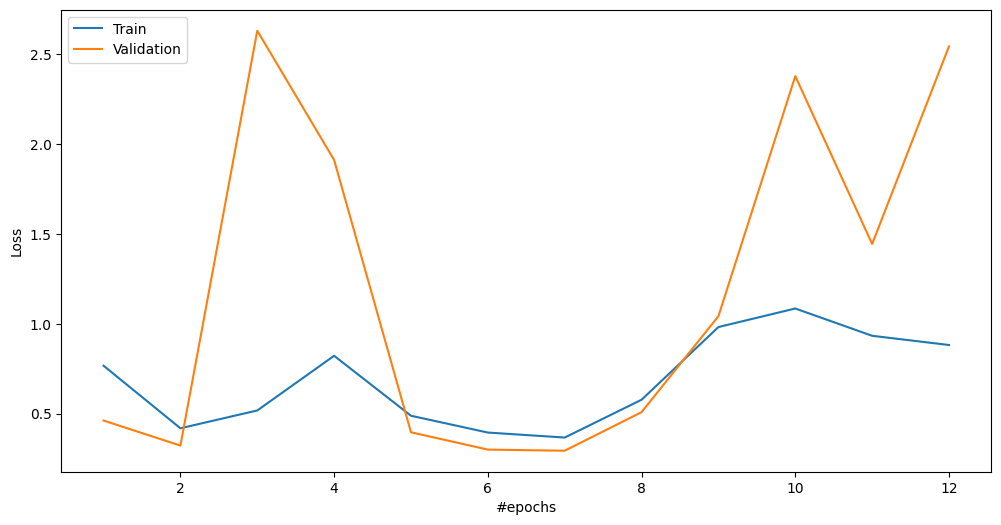

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# predict the class labels: 
# %%time
pred = np.argmax(model.predict(X_test), axis = 1)

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step


In [21]:
from sklearn.metrics import classification_report 

class_labels= ['0', '1']
labels = [class_labels[i] for i in range(2)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1113
           1       0.87      0.93      0.90      1795

    accuracy                           0.87      2908
   macro avg       0.87      0.85      0.86      2908
weighted avg       0.87      0.87      0.87      2908



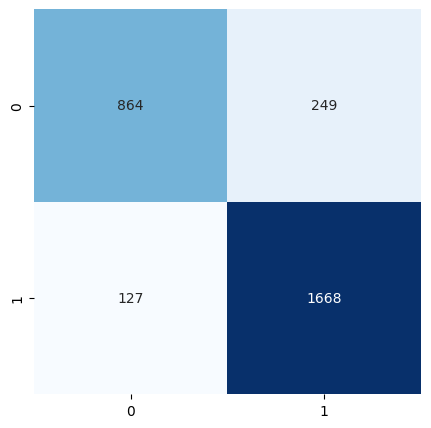

In [22]:
# confusion matrix: 
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Blues', fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.show()

In [23]:
# classwise accuracy: 
import pandas as pd

classwise_acc = cmat.diagonal() / cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label': [class_labels[i] for i in range(2)], 'Accuracy': classwise_acc.tolist()}, columns=['Class_Label', 'Accuracy'])
cls_acc.set_index('Class_Label', inplace=True)  # Set the index to 'Class_Label'
cls_acc.style.format({"Accuracy": "{:,.2f}"}).bar(subset=["Accuracy"], color='tomato')

,Accuracy
Class_Label,
0,77.63
1,92.92


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


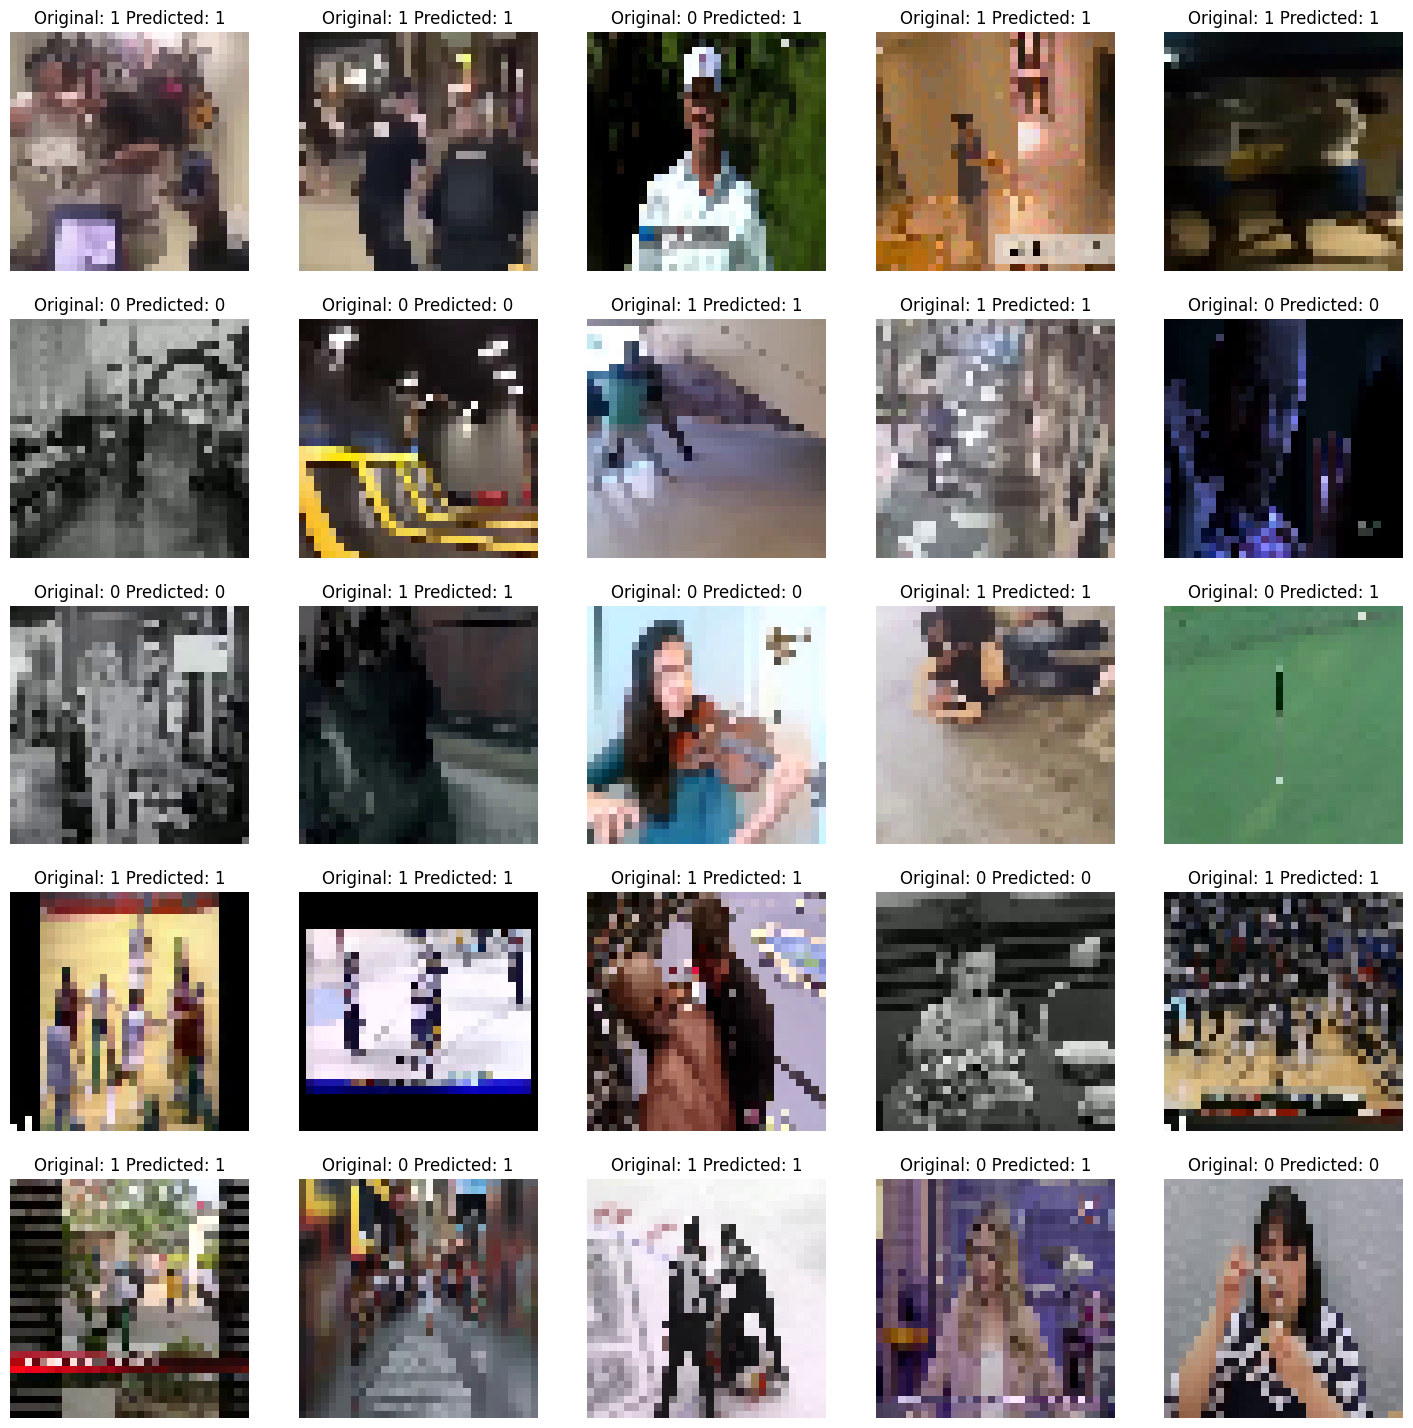

In [24]:
# prediction of unseen data: 
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

In [25]:
"""

code for converting videos to frames: 

PATH_violence = "ENTER_PATH_OF_VIOLENT_VIDEOS"

os.makedirs('./data/Violence',exist_ok=True)
for path in tqdm(glob.glob(PATH_violence+'/*')):
    fname = os.path.basename(path).split('.')[0]
    vidcap = cv2.VideoCapture(path)
    success,image = vidcap.read()
    count = 0
    while success:
        if count % 5 == 0:
            cv2.imwrite("./data/Violence/{}-{}.jpg".format(fname,str(count).zfill(4)),image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1
        
"""

'\n\ncode for converting videos to frames: \n\nPATH_violence = "ENTER_PATH_OF_VIOLENT_VIDEOS"\n\nos.makedirs(\'./data/Violence\',exist_ok=True)\nfor path in tqdm(glob.glob(PATH_violence+\'/*\')):\n    fname = os.path.basename(path).split(\'.\')[0]\n    vidcap = cv2.VideoCapture(path)\n    success,image = vidcap.read()\n    count = 0\n    while success:\n        if count % 5 == 0:\n            cv2.imwrite("./data/Violence/{}-{}.jpg".format(fname,str(count).zfill(4)),image)     # save frame as JPEG file      \n        success,image = vidcap.read()\n        count += 1\n        \n'